# Defining AOIs across reference images

Sometimes, we might be interested in AOIs that are spatially far apart from each other, eventually far enough that we cannot make one reference image that includes them all.

In this case, we can take one reference image for each AOI and analyse gaze data on and between these.

This guide will show you how to 

- load data from multiple reference image enrichments into one datafile
- visualize multiple reference images next to each other
- visualize the order in which the AOIs were visited.

## Loading data from multiple folders

Once you've created multiple reference image mapper enrichments and downloaded them, we recommend putting all relevant enrichments into one folder.

To download the files recursively, we will first define some helper functions.

In [1]:
import os
import numpy as np
import pandas as pd

# Define the folder with our data
## change here to new path
path_to_folders = './reference_image_enrichments/'

def get_file_list(file_name, directory = path_to_folders):
    """
    returns a list of paths to all files of a given name in subfolders of the given directory
    """
    all_aoi_recordings = os.listdir(directory)
    return [f"{directory}{aoi}/{file_name}" for aoi in all_aoi_recordings]

# define a function that extracts the image name from the path
extract_name = lambda name: name.split('MAPPER_')[1].split('_csv')[0]

def load_csv_files(file_name):  
    """
    recursively loads csv files and concatenates them in a long data frame
    """
    file_list = get_file_list(file_name)
    data = pd.DataFrame()
    
    for file in file_list:
        
        df = pd.read_csv(file)
        df['AOI'] = extract_name(file)
        
        data = pd.concat([data,df], ignore_index = True)
        
    return data

## Load and display an array of reference images

In [10]:
images

['./reference_image_enrichments/Art-_Gallery_Picture_Viewing_REFERENCE-IMAGE-MAPPER_Gary_Cain_walking_csv/reference_image.jpeg',
 './reference_image_enrichments/Art-_Gallery_Picture_Viewing_REFERENCE-IMAGE-MAPPER_Adel_Dauood_2_walking_csv/reference_image.jpeg',
 './reference_image_enrichments/Art-_Gallery_Picture_Viewing_REFERENCE-IMAGE-MAPPER_Ingerlise_Vikne_walking_csv/reference_image.jpeg',
 './reference_image_enrichments/Art-_Gallery_Picture_Viewing_REFERENCE-IMAGE-MAPPER_Gunlief_Grube_walking_csv/reference_image.jpeg',
 './reference_image_enrichments/Art-_Gallery_Picture_Viewing_REFERENCE-IMAGE-MAPPER_Adel_Dauood_3_walking_csv/reference_image.jpeg',
 './reference_image_enrichments/Art-_Gallery_Picture_Viewing_REFERENCE-IMAGE-MAPPER_Christopher_Blanc_2_walking_csv/reference_image.jpeg']

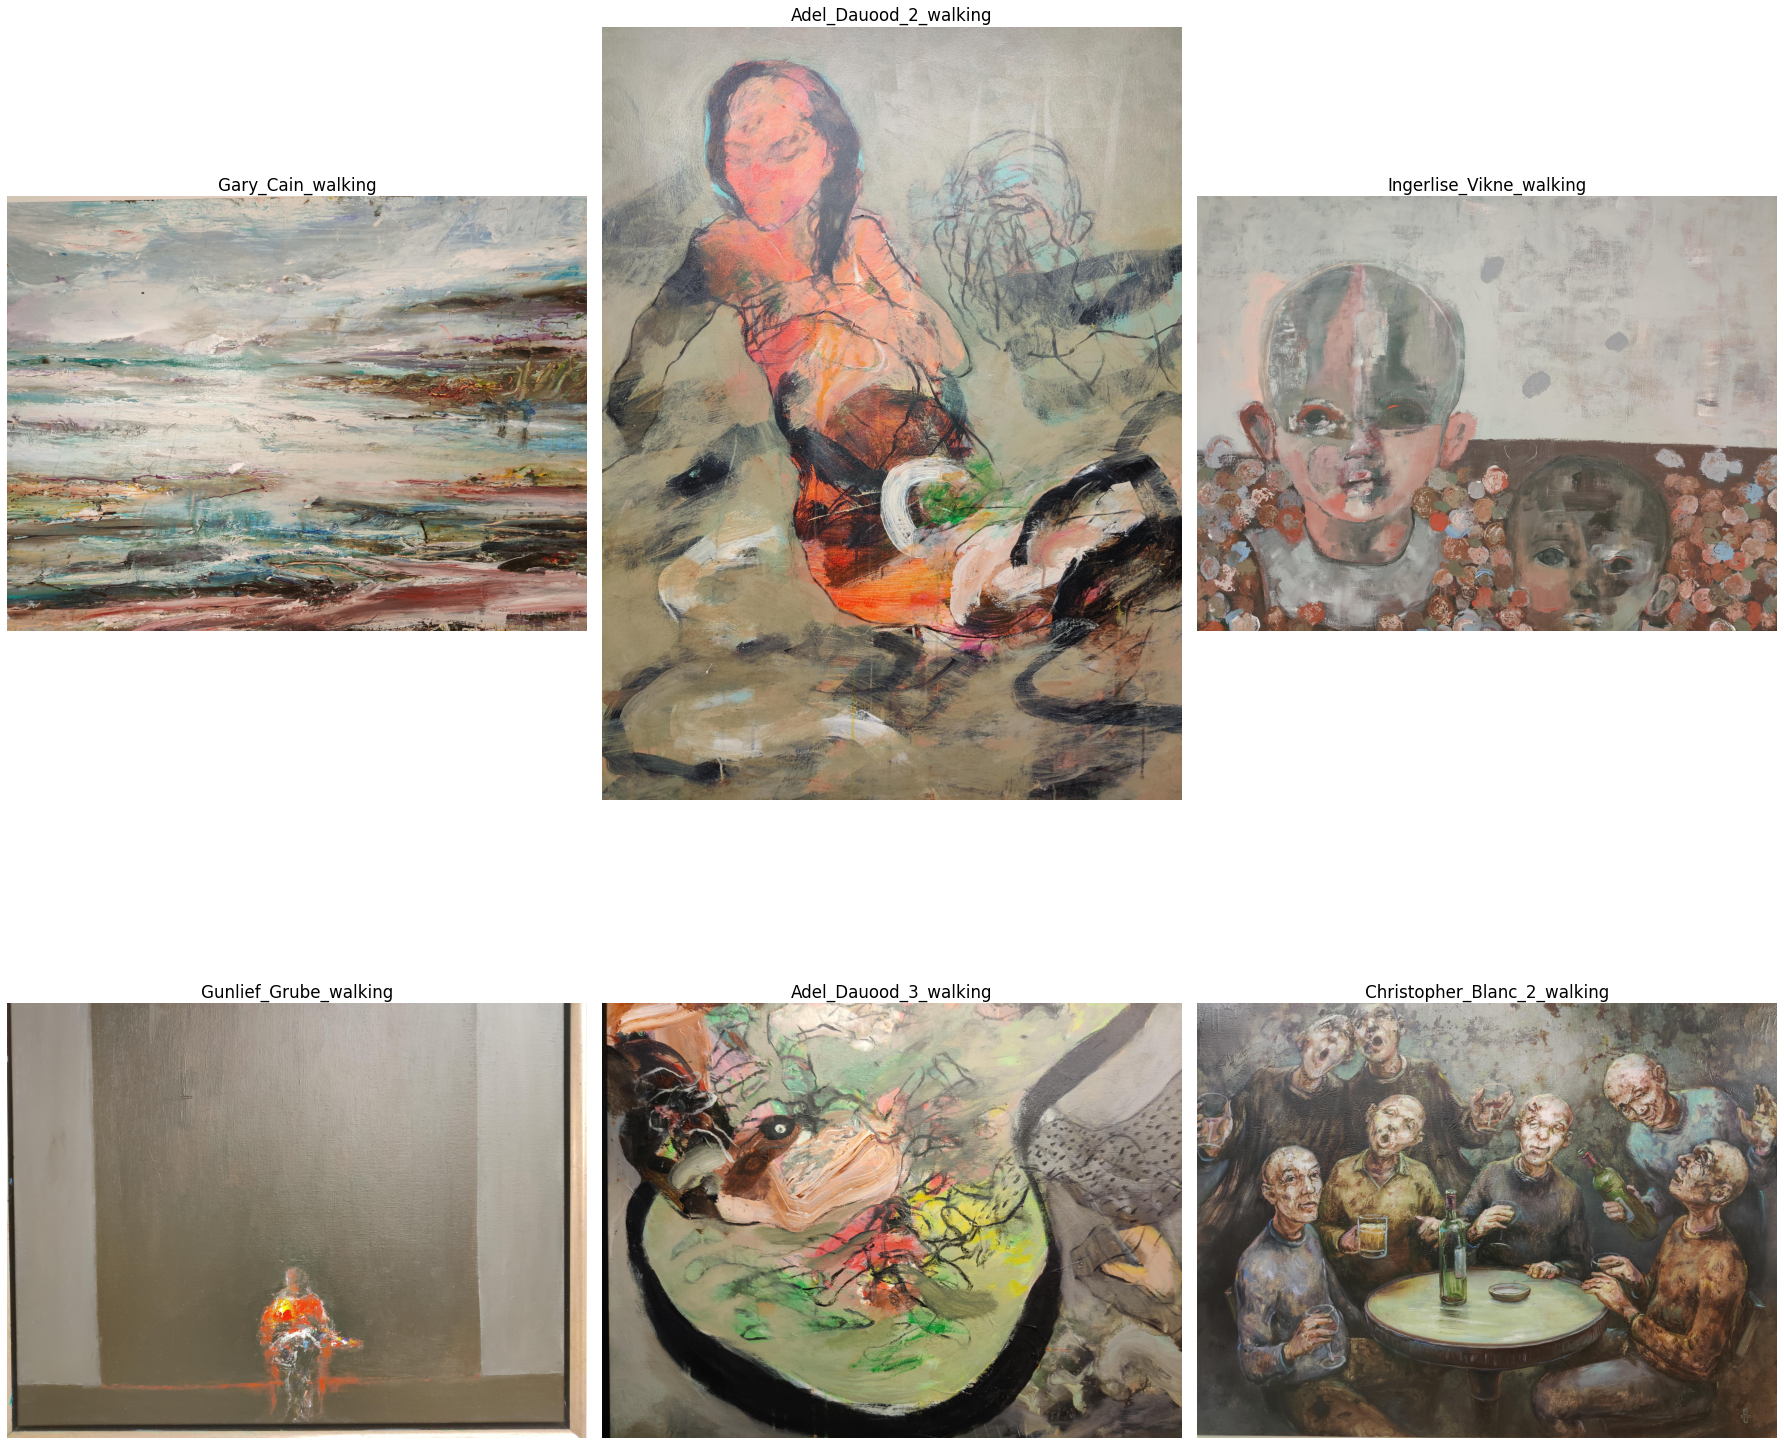

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
plt.rcParams.update({'font.size': 14})

# Load images
images = get_file_list('reference_image.jpeg')

# Initialize list of AOI names
aoi_names = []

# create a plot for the images
fig_reference, ax_reference = plt.subplots(int(np.ceil(len(images)/3)),3, figsize = (25, 25))

for ax, im in zip(ax_reference.flatten(), images):
    reference_image = Image.open(im)
    ax.imshow(np.asarray(reference_image))
    name = extract_name(im)
    aoi_names.append(name)
    ax.set_title(name)
    ax.set_axis_off()
    
plt.tight_layout()

Each reference image shows an individual painting and can be thought of as one Area of Interest. We can use the name of the reference image mapper to identify the paintings and the fixations that belong to each of them.

## Loading fixation data

In [3]:
fixations = load_csv_files('fixations.csv')
# defining a list of recording id names
recordings = np.unique(fixations['recording id'])

## Filter the data for fixation on a reference image

The fixation data from the Reference Image Mapper will include fixations inside and outside the reference image. To select only fixations inside the reference image, we can filter them with the help of the column **'gaze detected on reference image'**.

In [4]:
print(f"The fixation data frame originally contained {len(fixations)} samples.")

# filter the data frames 
fixations_unfiltered = fixations.copy()
fixations = fixations[fixations['fixation detected in reference image']] 

print(f"After cleaning, the fixation data frame contained {len(fixations)} samples.")

fixations.head()

The fixation data frame originally contained 32495 samples.
After cleaning, the fixation data frame contained 1617 samples.


section id  \
246  3d9fe3c3-9ced-4c23-bd06-327b52b46a58   
247  3d9fe3c3-9ced-4c23-bd06-327b52b46a58   
320  3d9fe3c3-9ced-4c23-bd06-327b52b46a58   
321  3d9fe3c3-9ced-4c23-bd06-327b52b46a58   
322  3d9fe3c3-9ced-4c23-bd06-327b52b46a58   

                             recording id  fixation id  start timestamp [ns]  \
246  71fadd82-ed00-48f1-863b-6bf16a62b095          254   1636035853513854036   
247  71fadd82-ed00-48f1-863b-6bf16a62b095          255   1636035853733877036   
320  71fadd82-ed00-48f1-863b-6bf16a62b095          328   1636035886821858036   
321  71fadd82-ed00-48f1-863b-6bf16a62b095          329   1636035887365876036   
322  71fadd82-ed00-48f1-863b-6bf16a62b095          330   1636035887557866036   

      end timestamp [ns]  duration [ms]  fixation detected in reference image  \
246  1636035853634012036            120                                  True   
247  1636035853917847036            183                                  True   
320  1636035886977845036            155                                  True   
321  1636035887537831036            171                                  True   
322  1636035887761878036            204                                  True   

     fixation x [px]  fixation y [px]                AOI  
246            710.0           2695.0  Gary_Cain_walking  
247           1291.0           2849.0  Gary_Cain_walking  
320           1900.0           1602.0  Gary_Cain_walking  
321           2376.0           1420.0  Gary_Cain_walking  
322           2461.0           1265.0  Gary_Cain_walking

## Align the fixation timestamps to the sections start.

Since our participants all started their walk in the museum at different times, we will align the timestamp of each fixation to the start of each section.

In [5]:
sections = load_csv_files('sections.csv')

def align_timestamps(df, sections, time_columns, recordings = recordings):
    for recording in recordings:
        recording_idx = df[df['recording id'] == recording].index
        section_start_time = min(sections[sections['recording id'] == recording]['section start time [ns]'].values)
        for column in time_columns:
            aligned_name = f'aligned {column}'
            df.loc[recording_idx, aligned_name] = (df.loc[recording_idx, column] - section_start_time)

align_timestamps(fixations, sections, ['start timestamp [ns]', 'end timestamp [ns]'])

## Visual journey
Having every single AOI in an individual reference image poses a challenge for visualizing the fixations across them. This is mainly because every AOI now lives in their own coordinate system, and we have lost the mapping between them.

This means, we cannot show a classical scanpath that connects different fixations between the AOIs. Instead, we will show how the eyes travel from image to image, using an approach we call **visual journey**. 

In the visual journey, we visualize in which reference images were visited in time, rather where the observer looked in space. 

In [6]:
# re-label the recording id for clearer naming
id_name_dict = {}
for rec_id, rec_name in zip (sections['recording id'], sections['recording name']):
    id_name_dict[rec_id] = rec_name
    
fixations['recording name'] = fixations['recording id'].replace(id_name_dict)

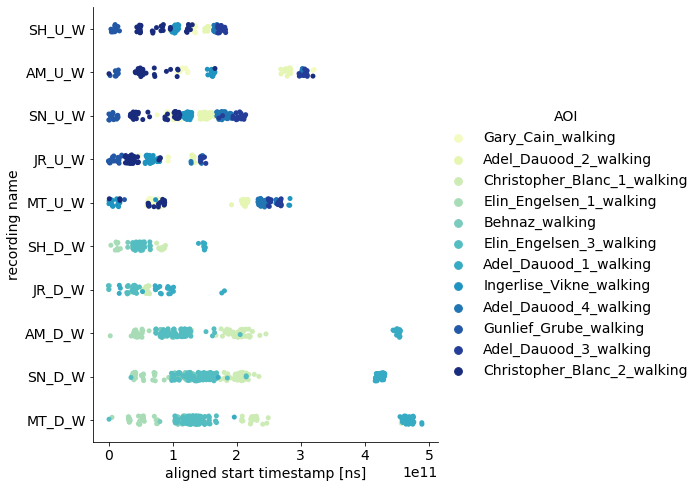

In [7]:
import seaborn as sns

sns.catplot(
    data=fixations,
    x="aligned start timestamp [ns]",
    y="recording name",
    hue="AOI",
    aspect=1,
    linewidth=0,
    s=5,
    palette = 'YlGnBu',
    height = 7
);

## Gaze Points over Time
The spatial journey gives us a fist idea in which order the images are visited, but might be difficult to read. An alternative visualization that gives us a better grasp of the spatial distribution of gaze is similar to the fixation scanpath we used for AOIs withoin one reference image. 

However, instead of conntecting the fixations via lines, we will color code them acording to the time when the AOI was visited. This gives us an idea about the temporal order, in which AOIs were visited, and makes it easy to distinguish between fixation clusters from different visits to the AOI.

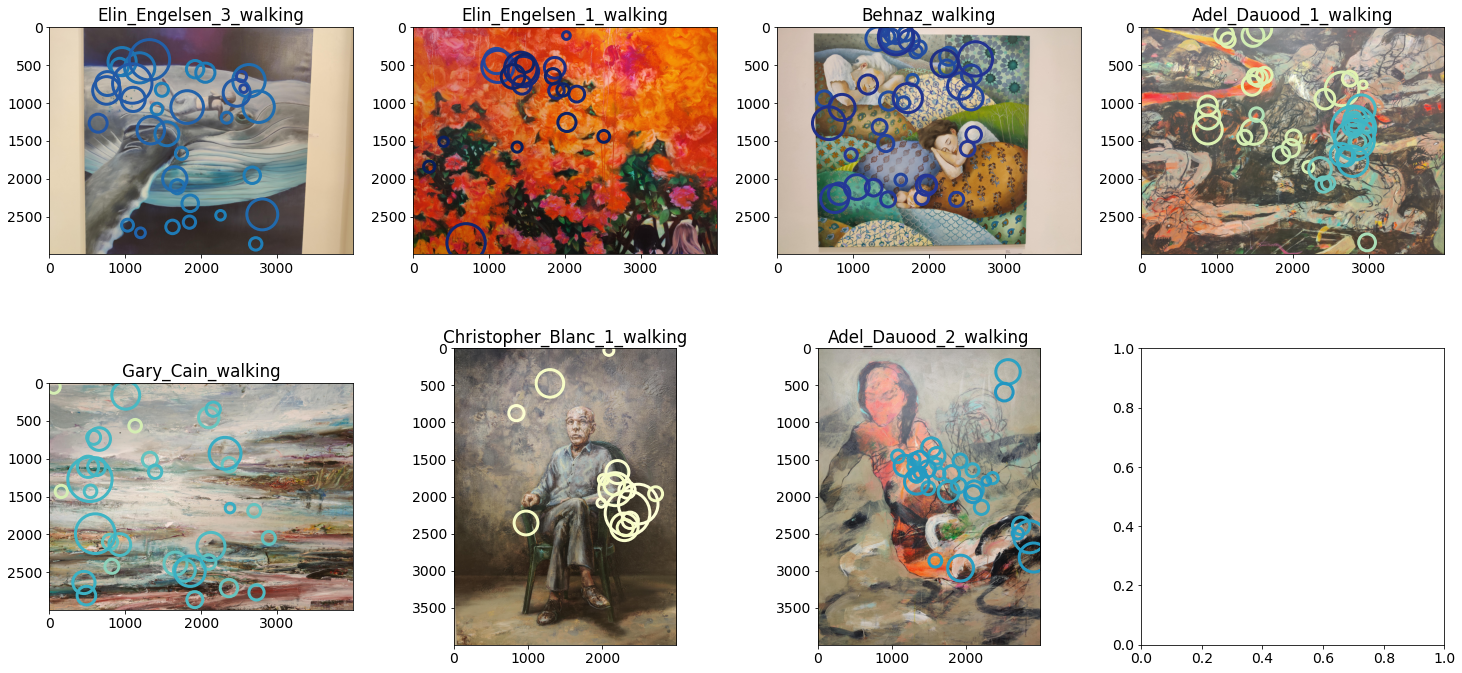

In [8]:
from matplotlib import cm

# take one example recording for the visualization
example_recording = recordings[0]
example_fixations = fixations[fixations['recording id'] == example_recording]

# select a color map and find the last timestamp in our data set
cmap = cm.get_cmap('YlGnBu')
max_dur = max(example_fixations['aligned start timestamp [ns]'])

# sort the reference image by first fixation
first_fixation = example_fixations.groupby('AOI').describe()['aligned start timestamp [ns]']['min']
sorted_image_index = first_fixation.argsort().values

sorted_image_path = np.array(images)[sorted_image_index]
# plot the reference images in order
fig_visual_journey, ax_visual_journey = plt.subplots(int(np.ceil(len(sorted_image_index)/4)),4, figsize = (25,12))
for ax, im in zip(ax_visual_journey.flatten(), sorted_image_path):
    reference_image = Image.open(im)
    ax.imshow(np.asarray(reference_image))
    name = extract_name(im)
    aoi_names.append(name)
    ax.set_title(name)


# plot fixations on top of the reference images
for ax, aoi_idx in zip(ax_visual_journey.flatten()[sorted_image_index], sorted_image_index):
    aoi_fixations = example_fixations[example_fixations['AOI'] == first_fixation.index[aoi_idx]]
    colors = [cmap(x/max_dur) for x in aoi_fixations['aligned start timestamp [ns]']]
    
    ax.scatter(aoi_fixations['fixation x [px]'],
               aoi_fixations['fixation y [px]'],
               edgecolors = colors, 
               facecolors = 'none',
               linewidth = 3, 
               s = aoi_fixations['duration [ms]']);   

We can clearly see the most fixations within one AOI were made at a similar time. In this case, Christopher Blanc 2 seems to be an exception, were the observer revisited the painting and inspected one specific area.

## Metrics

With all fixation data points in one data frame, we can compute hit rate, dwell time and time to first contact in the same way they were computed for multiple AOIs inside one reference image (How-To Define areas of interest and compute basic metrics).

However, there are some caveats to keep in mind:

### 1. AOI sizes are harder to compare. 
The size of the reference image is not equal to the size of the original image. To compare differnt AOIs with respect to their size, use real-world features, like the physical extent of your AOI rather than features measured on the reference image.

### 2. AOIs don't become inspectible at the same time.
When working with spatially and temporally disjointed AOIs, keep in mind that the participants in your study won't get to see them simultaneously, but in a specific spatial and temporal order (e.g. in order of the rooms in our gallery). That has consequences for the time of first contact - when you compute the time of first contact from the start of the study, this metric will reflect the order in which AOIs became inspectible, rather than the order in which participants chose to visit them. 

## Summary:

When you are working with the reference image mapper, you can either decide to mark AOIs inside one reference image, and compute metric across them, or to treat each reference image mapper as an individual AOI. Both approaches can be combined and every reverence image supports either. 

Which approach works better for you depends on your research question, the environment and your study design. 